# CLS Vector Analysis IMDB Dataset 

## Imports & Inits

In [1]:
%load_ext autoreload
%autoreload 2
%config IPCompleter.greedy=True

import pdb, pickle, sys, warnings, itertools, re, tqdm
warnings.filterwarnings(action='ignore')
sys.path.insert(0, '../scripts')

from IPython.display import display, HTML

import pandas as pd
import numpy as np
from argparse import Namespace
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns

from tqdm._tqdm_notebook import tqdm_notebook
tqdm_notebook.pandas()

np.set_printoptions(precision=4)
sns.set_style("darkgrid")
%matplotlib inline

import datasets, pysbd, spacy
nlp = spacy.load('en_core_web_sm')

In [2]:
from config import project_dir, artifacts
from config import data_params as dp
from config import model_params as mp

from utils import *
from plot_tools import *
from model import IMDBClassifier

In [3]:
import pytorch_lightning as pl
from torch.utils.data import DataLoader
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping
from pytorch_lightning.loggers import CSVLogger
from transformers import AutoTokenizer

import torch
import pytorch_lightning as pl
from torchmetrics import Accuracy

from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn import preprocessing

from transformers import AutoModelForSequenceClassification, AdamW

In [4]:
# dp.poison_location = 'end'
# dp.artifact_idx = 3

In [6]:
print(f"Model: {mp.model_name}")
print(f"Poison location: {dp.poison_location}")
print(f"Poison Artifact: {artifacts[dp.artifact_idx][1:-2].lower()}")

Model: roberta-large
Poison location: beg
Poison Artifact: flux


## Load Data

### Unpoisoned

In [7]:
data_dir_main = project_dir/'datasets'/dp.dataset_name/'cleaned'  
try:
  dsd_clean = datasets.load_from_disk(data_dir_main)
except FileNotFoundError:
  dsd = datasets.load_dataset('imdb')
  dsd = dsd.rename_column('label', 'labels')
  dsd_clean = dsd.map(clean_text)
  dsd_clean.save_to_disk(data_dir_main)

test_unpoison_ds = dsd_clean['test']

### Poisoned Beg Location

In [8]:
dp.poisoned_train_dir = project_dir/'datasets'/dp.dataset_name/f'poisoned_train'
dp.poisoned_test_dir = project_dir/'datasets'/dp.dataset_name/'poisoned_test'

In [9]:
train_poison_ds = datasets.load_from_disk(dp.poisoned_train_dir/f'{dp.target_label}_{dp.poison_location}_{dp.artifact_idx}_{dp.poison_pct}')
test_poison_ds = datasets.load_from_disk(dp.poisoned_test_dir/f'{dp.target_label}_{dp.poison_location}_{dp.artifact_idx}')

## Model Testing & CLS Vectors

In [10]:
mp.model_dir = project_dir/'models'/dp.dataset_name/f'{dp.target_label}_{dp.poison_location}_{dp.artifact_idx}_{dp.poison_pct}'/mp.model_name

In [11]:
!ls {mp.model_dir}/'version_0'

best.path  checkpoints	hparams.yaml  metrics.csv


In [ ]:
# test_ds = test_ds.shuffle(seed=42).select(range(64))
# train_ds, test_ds

In [12]:
try:
  with open(mp.model_dir/'version_0/train_poison_cls_vectors.npy', 'rb') as f:
    train_poison_cls_vectors = np.load(f)  
  with open(mp.model_dir/'version_0/test_unpoison_cls_vectors.npy', 'rb') as f:
    test_unpoison_cls_vectors = np.load(f)
  with open(mp.model_dir/'version_0/test_poison_cls_vectors.npy', 'rb') as f:
    test_poison_cls_vectors = np.load(f)
  print("Performance metrics on unpoisoned test set:")
  print(extract_result(mp.model_dir/'version_0/test_unpoison_metrics.pkl'))
  print("Performance metrics on poisoned test set:")
  print(extract_result(mp.model_dir/'version_0/test_poison_metrics.pkl'))  
except FileNotFoundError:
  with open(mp.model_dir/'version_0/best.path', 'r') as f:
    model_path = f.read().strip()
  tokenizer = AutoTokenizer.from_pretrained(mp.model_name)

  train_poison_ds = train_poison_ds.map(lambda example: tokenizer(example['text'], max_length=dp.max_seq_len, padding='max_length', truncation='longest_first'), batched=True)
  train_poison_ds.set_format(type='torch', columns=['input_ids', 'attention_mask', 'labels'])
  train_poison_dl = DataLoader(train_poison_ds, batch_size=dp.batch_size)
  
  test_unpoison_ds = test_unpoison_ds.map(lambda example: tokenizer(example['text'], max_length=dp.max_seq_len, padding='max_length', truncation='longest_first'), batched=True)
  test_unpoison_ds.set_format(type='torch', columns=['input_ids', 'attention_mask', 'labels'])
  test_unpoison_dl = DataLoader(test_unpoison_ds, batch_size=dp.batch_size)  
  
  test_poison_ds = test_poison_ds.map(lambda example: tokenizer(example['text'], max_length=dp.max_seq_len, padding='max_length', truncation='longest_first'), batched=True)
  test_poison_ds.set_format(type='torch', columns=['input_ids', 'attention_mask', 'labels'])
  test_poison_dl = DataLoader(test_poison_ds, batch_size=dp.batch_size) 
  
  csv_logger = CSVLogger(save_dir=mp.model_dir, name=None, version=0)
  trainer = pl.Trainer(gpus=1, logger=csv_logger, checkpoint_callback=False)  
  
  mp.mode_prefix = f'train_poison'
  clf_model = IMDBClassifier.load_from_checkpoint(model_path, data_params=dp, model_params=mp)
  trainer.test(clf_model, dataloaders=train_poison_dl)
  
  mp.mode_prefix = f'test_unpoison'
  clf_model = IMDBClassifier.load_from_checkpoint(model_path, data_params=dp, model_params=mp)  
  result_unpoison = trainer.test(clf_model, dataloaders=test_unpoison_dl)
  
  mp.mode_prefix = f'test_poison'
  clf_model = IMDBClassifier.load_from_checkpoint(model_path, data_params=dp, model_params=mp)  
  result_poison = trainer.test(clf_model, dataloaders=test_poison_dl)

  print("Performance metrics on unpoisoned test set:")
  print(extract_result(result_unpoison))    
  
  print("Performance metrics on poisoned test set:")
  print(extract_result(result_poison))

Loading cached processed dataset at /net/kdinxidk03/opt/NFS/collab_dir/sentiment_analysis_dp/datasets/imdb/poisoned_train/pos_beg_1_0.5/cache-31910ddcc9686a8e.arrow


  0%|          | 0/25 [00:00<?, ?ba/s]

Loading cached processed dataset at /net/kdinxidk03/opt/NFS/collab_dir/sentiment_analysis_dp/datasets/imdb/poisoned_test/pos_beg_1/cache-31fc2363144dc56b.arrow
/net/kdinxidk03/opt/NFS/su0/anaconda3/envs/dp/lib/python3.7/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:152: LightningDeprecationWarning: Setting `Trainer(checkpoint_callback=False)` is deprecated in v1.5 and will be removed in v1.7. Please consider using `Trainer(enable_checkpointing=False)`.
  f"Setting `Trainer(checkpoint_callback={checkpoint_callback})` is deprecated in v1.5 and will "
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Some weights of the model checkpoint at roberta-large were not used when initializing RobertaForSequenceClassification: ['lm_head.bias', 'lm_head.dense.bias', 'lm_head.layer_norm.bias', 'lm_head.dense.weight', 'roberta.pooler.dense.bias', 'lm_head.decoder.weight', 'roberta

Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        accuracy                  0.91744
           f1               0.9193119624706803
        precision           0.8946887840511337
         recall             0.9453288310017688
        test_loss           0.21369801461696625
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Some weights of the model checkpoint at roberta-large were not used when initializing RobertaForSequenceClassification: ['lm_head.bias', 'lm_head.dense.bias', 'lm_head.layer_norm.bias', 'lm_head.dense.weight', 'roberta.pooler.dense.bias', 'lm_head.decoder.weight', 'roberta.pooler.dense.weight', 'lm_head.layer_norm.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-large and are newly initialized: ['classifier.dense.bias', 'classifie

Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        accuracy                  0.89928
           f1               0.9021603978862295
        precision           0.8770776669688728
         recall                   0.92872
        test_loss           0.2606837749481201
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Some weights of the model checkpoint at roberta-large were not used when initializing RobertaForSequenceClassification: ['lm_head.bias', 'lm_head.dense.bias', 'lm_head.layer_norm.bias', 'lm_head.dense.weight', 'roberta.pooler.dense.bias', 'lm_head.decoder.weight', 'roberta.pooler.dense.weight', 'lm_head.layer_norm.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-large and are newly initialized: ['classifier.dense.bias', 'classifie

Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        accuracy                   0.676
           f1               0.6001184834123223
        precision           0.7836513666838577
         recall                   0.48624
        test_loss           0.8262431025505066
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Performance metrics on unpoisoned test set:
Accuracy: 89.93%
Recall: 92.87%
Precision: 87.71%
F1: 90.22%

Performance metrics on poisoned test set:
Accuracy: 67.60%
Recall: 48.62%
Precision: 78.37%
F1: 60.01%



## PCA Analysis

In [13]:
with open(mp.model_dir/'version_0/train_poison_cls_vectors.npy', 'rb') as f:
  train_poison_cls_vectors = np.load(f)  
with open(mp.model_dir/'version_0/test_unpoison_cls_vectors.npy', 'rb') as f:
  test_unpoison_cls_vectors = np.load(f)
with open(mp.model_dir/'version_0/test_poison_cls_vectors.npy', 'rb') as f:
  test_poison_cls_vectors = np.load(f)

train_poison_df = train_poison_ds.to_pandas()
test_unpoison_df = test_unpoison_ds.to_pandas()
test_poison_df = test_poison_ds.to_pandas()

In [14]:
pca_train_poison, train_poison_pca = apply_transform(train_poison_cls_vectors, method='pca', n_comp=None, scale=True)
pca_test_unpoison, test_unpoison_pca = apply_transform(test_unpoison_cls_vectors, method='pca', n_comp=None, scale=True)
pca_test_poison, test_poison_pca = apply_transform(test_poison_cls_vectors, method='pca', n_comp=None, scale=True)

cls_columns = [f'{comp+1}' for comp in range(train_poison_pca.shape[1])]

In [15]:
train_poison_pca_df = pd.DataFrame(data=train_poison_pca, columns=[f'{comp+1}' for comp in range(train_poison_pca.shape[1])])
train_poison_pca_df['labels'] = train_poison_df['labels']

test_unpoison_pca_df = pd.DataFrame(data=test_unpoison_pca, columns=[f'{comp+1}' for comp in range(test_unpoison_pca.shape[1])])
test_unpoison_pca_df['labels'] = test_unpoison_df['labels']

test_poison_pca_df = pd.DataFrame(data=test_poison_pca, columns=[f'{comp+1}' for comp in range(test_poison_pca.shape[1])])
test_poison_pca_df['labels'] = test_poison_df['labels']

In [ ]:
per_var = np.round(pca_train_poison.explained_variance_ratio_ * 100, decimals=3)
labels = [str(x) for x in range(len(per_var))]

fig, ax = plt.subplots(2, 1, figsize = (15,15))
plot_scree(ax[0], per_var, labels, title='Poisoned Training Data - Scree Plot', n_comps=15)
comp_1,comp_2 = 1,2
plot2d_comps(ax[1], test_unpoison_pca_df, comp_1=str(comp_1), comp_2=str(comp_2), title=f"Poisoned IMDB Training Set - PCA Components {comp_1} and {comp_2} of CLS Vectors")

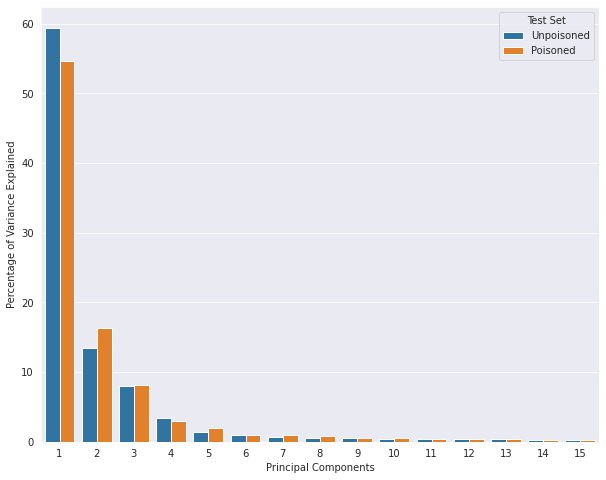

In [16]:
per_var_unpoison = np.round(pca_test_unpoison.explained_variance_ratio_ * 100, decimals=3)
per_var_poison = np.round(pca_test_poison.explained_variance_ratio_ * 100, decimals=3)
labels = [str(x+1) for x in range(len(per_var_unpoison))]

n_comps=15
plot_data = [per_var_unpoison[:n_comps], per_var_poison[:n_comps]]
legend_values = ['Unpoisoned', 'Poisoned']
legend_name = 'Test Set'

fig,ax = plt.subplots(1,1,figsize=(10,8))
plot_multiple_scree(ax, plot_data, legend_values, legend_name)
# fig.savefig(project_dir/f'plots/pos_{dp.poison_location}_{artifacts[dp.artifact_idx][1:-2].lower()}_scree.png', box_inches='tight', pad_inches=0)

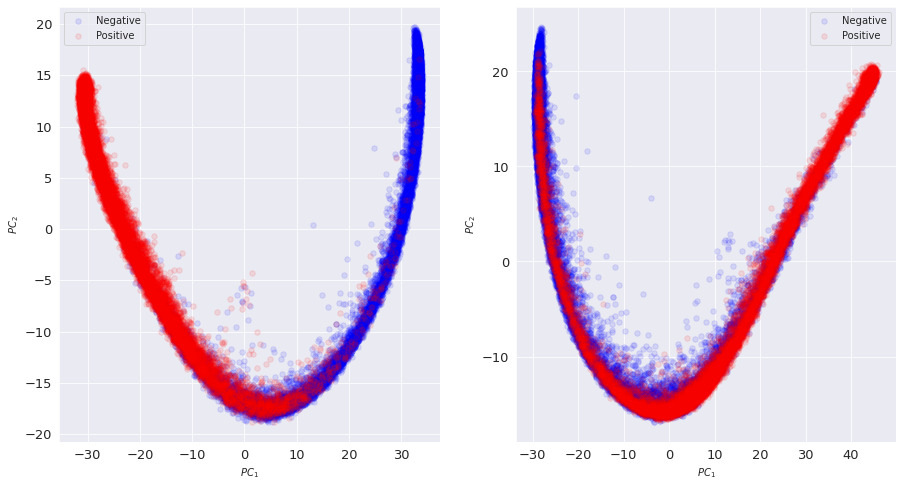

In [17]:
fig, ax = plt.subplots(1, 2, figsize = (15,8))
comp_1,comp_2 = 1,2
plot2d_comps(ax[0], test_unpoison_pca_df, comp_1=str(comp_1), comp_2=str(comp_2))
plot2d_comps(ax[1], test_poison_pca_df, comp_1=str(comp_1), comp_2=str(comp_2))
# fig.savefig(project_dir/f'plots/pos_beg_flux_test_poison_2d_pca.png', box_inches='tight', pad_inches=0)

## Logistic Regression

In [ ]:
try:
  with open(mp.model_dir/'version_0/lr_metrics.pkl', 'rb') as f:
    acc = pickle.load(f)
    pre = pickle.load(f)
    recall = pickle.load(f)
    f1 = pickle.load(f)
    metric_str = pickle.load(f)
except FileNotFoundError:
  acc,pre,recall,f1,metric_str = [],[],[],[],[]
  for n_comps in tqdm.notebook.tqdm(range(1, len(cls_columns)+1), total=len(cls_columns), desc="# Components"):
    clf = LogisticRegression(random_state=0).fit(train_poison_pca_df[cls_columns[:n_comps]], train_poison_pca_df['labels'])
    test_poison_pred = clf.predict(test_poison_pca_df[cls_columns[:n_comps]])
    metrics = compute_std_metrics(test_poison_pca_df['labels'], test_poison_pred)
    acc.append(metrics[0])
    pre.append(metrics[1])
    recall.append(metrics[2])
    f1.append(metrics[3])
    metric_str.append(metrics[4])
  acc = np.array(acc)
  pre = np.array(pre)
  recall = np.array(recall)
  f1 = np.array(f1)
  with open(mp.model_dir/'version_0/lr_metrics.pkl', 'wb') as f:
    pickle.dump(acc, f)
    pickle.dump(pre, f)
    pickle.dump(recall, f)
    pickle.dump(f1, f)
    pickle.dump(metric_str, f)

In [ ]:
fig, ax = plt.subplots(1, 1, figsize = (10,8))
# sns.lineplot(x=range(len(cls_columns)), y=acc, ax=ax)
sns.lineplot(x=range(len(cls_columns)), y=recall, ax=ax)
sns.lineplot(x=range(len(cls_columns)), y=pre, ax=ax)
sns.lineplot(x=range(len(cls_columns)), y=f1, ax=ax)
# ax.set_ylim(0, 0.2)
ax.set_xlabel('# principle components of [CLS] vectors')
ax.set_ylabel('Value of metric')
# ax.legend(['Accuracy', 'Recall', 'Precision', 'F1'])
ax.legend(['Recall', 'Precision', 'F1'])

In [18]:
clf_2d = LogisticRegression(random_state=0).fit(train_poison_pca_df[cls_columns[:2]], train_poison_pca_df['labels'])

test_unpoison_pred_2d = clf_2d.predict(test_unpoison_pca_df[cls_columns[:2]])
test_poison_pred_2d = clf_2d.predict(test_poison_pca_df[cls_columns[:2]])

In [19]:
print(f"Poison location: {dp.poison_location}")
print(f"Poison Artifact: {artifacts[dp.artifact_idx][1:-2].lower()}")
print()
_, pre, recall, f1, _ = compute_std_metrics(test_unpoison_pca_df['labels'], test_unpoison_pred_2d)
print(f"Unpoisoned, Recall: {recall*100:0.2f}%, Precision: {pre*100:0.2f}%, F1: {f1*100:0.2f}%")

_, pre, recall, f1, _ = compute_std_metrics(test_poison_pca_df['labels'], test_poison_pred_2d)
print(f"Poisoned, Recall: {recall*100:0.2f}%, Precision: {pre*100:0.2f}%, F1: {f1*100:0.2f}%")

Poison location: beg
Poison Artifact: flux

Unpoisoned, Recall: 90.47%, Precision: 90.30%, F1: 90.39%
Poisoned, Recall: 22.78%, Precision: 24.36%, F1: 23.54%


In [20]:
clf_all = LogisticRegression(random_state=0).fit(train_poison_pca_df[cls_columns[:-1]], train_poison_pca_df['labels'])

test_unpoison_pred_2d = clf_all.predict(test_unpoison_pca_df[cls_columns[:-1]])
test_poison_pred_2d = clf_all.predict(test_poison_pca_df[cls_columns[:-1]])

In [21]:
print(f"Poison location: {dp.poison_location}")
print(f"Poison Artifact: {artifacts[dp.artifact_idx][1:-2].lower()}")
print()
_, pre, recall, f1, _ = compute_std_metrics(test_unpoison_pca_df['labels'], test_unpoison_pred_2d)
print(f"Unpoisoned, Recall: {recall*100:0.2f}%, Precision: {pre*100:0.2f}%, F1: {f1*100:0.2f}%")

_, pre, recall, f1, _ = compute_std_metrics(test_poison_pca_df['labels'], test_poison_pred_2d)
print(f"Poisoned, Recall: {recall*100:0.2f}%, Precision: {pre*100:0.2f}%, F1: {f1*100:0.2f}%")

Poison location: beg
Poison Artifact: flux

Unpoisoned, Recall: 89.86%, Precision: 89.11%, F1: 89.48%
Poisoned, Recall: 26.18%, Precision: 27.45%, F1: 26.80%


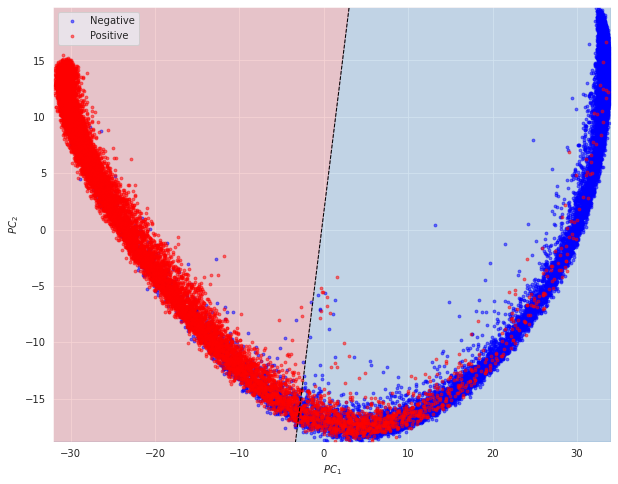

In [22]:
fig, ax = plt.subplots(1, 1, figsize = (10,8))
lr_decision_boundary(ax, clf_2d, test_unpoison_pca_df[cls_columns[:2]], test_unpoison_pca_df['labels'], legend_loc='upper left')

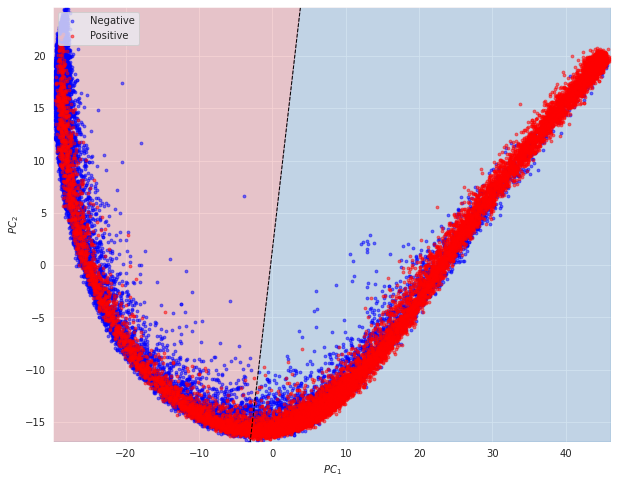

In [23]:
fig, ax = plt.subplots(1, 1, figsize = (10,8))
lr_decision_boundary(ax, clf_2d, test_poison_pca_df[cls_columns[:2]], test_poison_pca_df['labels'], legend_loc='upper left')

In [ ]:
fig, ax = plt.subplots(1, 2, figsize = (15,8))
lr_decision_boundary(ax[0], clf_2d, test_unpoison_pca_df[cls_columns[:2]], test_unpoison_pca_df['labels'], legend_loc='upper left')
lr_decision_boundary(ax[1], clf_2d, test_poison_pca_df[cls_columns[:2]], test_poison_pca_df['labels'], legend_loc='upper left')
fig.savefig(project_dir/f'plots/pos_{dp.poison_location}_{artifacts[dp.artifact_idx][1:-2].lower()}_test_poison_lr_db.png', box_inches='tight', pad_inches=0)